# Introduction 

In this case study, we will use the `Thermal_Generator` module to simulate the operational profiles for fossil generators (CCGT and Gas) in two electricity day-ahead markets in Germany and the UK and observe the effects of the carbon pricing mechanisms on their participation in the day-ahead markets.

In [1]:
import pandas as pd 
import numpy as np
from optlang import Objective, Variable, Constraint, Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from bokeh.plotting import figure, output_file, ColumnDataSource
from bokeh.io import show
from bokeh.models import HoverTool
from bokeh.layouts import column

from Generator import Thermal_Generator
from EPEX_Scrapping import epex_DAM

In [2]:
%matplotlib inline
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (23, 13)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

# CCGT in the UK

The data is already acquired for the [UK](https://www.nordpoolgroup.com/trading/Day-ahead-trading/) and the default configurations for a typical CCGT of 100 MW nominal capacity is provided.

In [3]:
gas_uk = pd.read_csv('data/CCGT_UK.csv', index_col='time', parse_dates=True)
gas_uk.head()

,fossil,electricity,carbon
time,,,
2017-01-01 00:00:00,16.4886,60.21,20.506706
2017-01-01 01:00:00,16.4886,60.71,20.506706
2017-01-01 02:00:00,16.4886,75.97,20.506706
2017-01-01 03:00:00,16.4886,60.74,20.506706
2017-01-01 04:00:00,16.4886,49.00,20.506706


In [4]:
gas_config = {'price': gas_uk, 'Name': 'CCGT_UK', 'Efficiency': [0.58, 0.47], 'Power': [100, 40], 
             'Emission_Factor': 0.25, 'CF': 0.75, 'Startup_cold_time': 2, 'Startup_dep_cost': 60,
             'Startup_fuel': 2.8, 'Minimum_downtime': None, 'Cost_fixed_OM': 28100, 'Cost_var_OM': 2.3}

CCGT_UK = Thermal_Generator(**gas_config)

In [5]:
CCGT_UK.optimization_problem()

Building the problem - Please wait
Variables
Constraints
Objective
Capacity Factor Constraint Activated 
Object Creation Finished


In [6]:
CCGT_UK.solve_optim_problem()

Solving the problem - please wait
Solver Status : OPTIMAL
Objective Value :  7587631.295974148


In [7]:
ccgt_uk = CCGT_UK.solution_values()

Gross Profit:  4.785329 € mil


In [8]:
for keys, vals in CCGT_UK.Finance_Metrics.items():
    print(keys, ':', vals)

Revenue : 70771870.2
OPEX : 65986540.27388887
Gross Profit : 4785329.926111135
Average STMC : 44.59493281604857


In [9]:
CCGT_UK.visualization_interactive(mode='Notebook')

Loading BokehJS ...

# Coal in the UK 

In [10]:
coal_uk = pd.read_csv('data/Coal_UK.csv', index_col='time', parse_dates=True)
coal_uk.head()

,fossil,electricity,carbon
time,,,
2015-01-01 00:00:00,11.36,60.21,20.506706
2015-01-01 01:00:00,11.36,60.71,20.506706
2015-01-01 02:00:00,11.36,75.97,20.506706
2015-01-01 03:00:00,11.36,60.74,20.506706
2015-01-01 04:00:00,11.36,49.00,20.506706


In [11]:
coal_config = {'price': coal_uk, 'Name': 'Coal_UK', 'Efficiency': [0.44, 0.38], 'Power': [100, 40], 
             'Emission_Factor': 0.34, 'CF': 0.6, 'Startup_cold_time': 10, 'Startup_dep_cost': 105,
             'Startup_fuel': 2.7, 'Minimum_downtime': None, 'Cost_fixed_OM': 38000, 'Cost_var_OM': 4.04}

Coal_UK = Thermal_Generator(**coal_config)

In [12]:
Coal_UK.Operation_Profile['Start-up Numbers']

In [13]:
Coal_UK.optimization_problem()

Building the problem - Please wait
Variables
Constraints
Objective
Capacity Factor Constraint Activated 
Object Creation Finished


In [14]:
Coal_UK.solve_optim_problem()

Solving the problem - please wait
Solver Status : OPTIMAL
Objective Value :  5512046.83787568


In [15]:
coal_uk_out = Coal_UK.solution_values()

Gross Profit:  1.722457 € mil


In [16]:
for keys, vals in Coal_UK.Finance_Metrics.items():
    print(keys, ':', vals)

Revenue : 56951975.4
OPEX : 55229517.60322021
Gross Profit : 1722457.7967797895
Average STMC : 50.1498928339683


In [17]:
Coal_UK.visualization_interactive(mode='Notebook')

Loading BokehJS ...

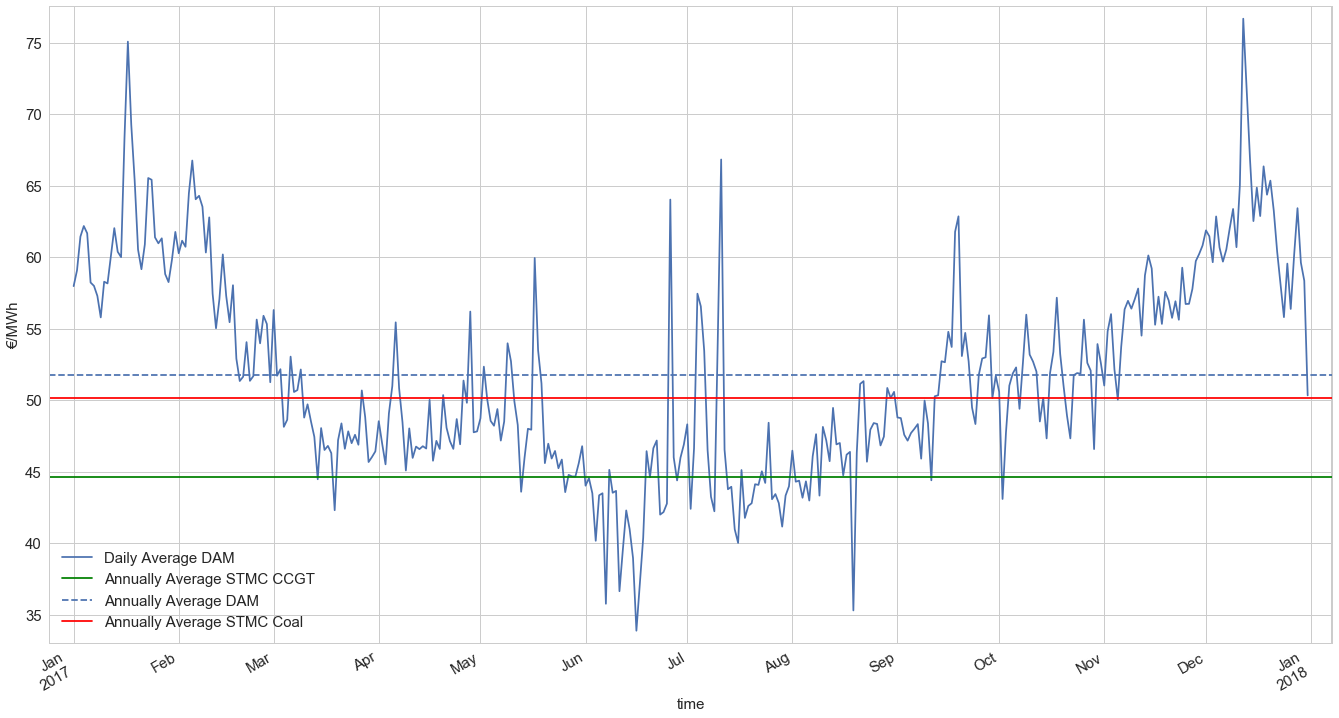

In [18]:
fig, ax = plt.subplots()
gas_uk.electricity.resample('D').mean().plot(ax=ax, label='Daily Average DAM')
ax.axhline(y= CCGT_UK.Finance_Metrics['Average STMC'], color='green', label='Annually Average STMC CCGT')
ax.axhline(y= gas_uk.electricity.mean(), linestyle = '--', label='Annually Average DAM')
ax.axhline(y= Coal_UK.Finance_Metrics['Average STMC'], color='red', label='Annually Average STMC Coal')
ax.legend(shadow='False', loc='best')
ax.set_ylabel('€/MWh')
fig.autofmt_xdate()
plt.margins(0.02)

# CCGT in Germany 

Now we will use our model to derive the operation plans for a CCGT and a Coal-fired Power Plant in Germany in 2017.  The DAM price for Germany in 2017 is obtained using `EPEX_Scrapping`. 

In [19]:
# Data Importation
ccgt_ge = pd.read_csv('data/CCGT_GE.csv', index_col='time', parse_dates=True)

print('Annually Average DAM price :', ccgt_ge.electricity.mean())

# Configuration for the coal-fired generator
gas_config = {'price': ccgt_ge, 'Name': 'CCGT_GE', 'Efficiency': [0.58, 0.47], 'Power': [100, 40], 
             'Emission_Factor': 0.25, 'CF': 0.75, 'Startup_cold_time': 2, 'Startup_dep_cost': 60,
             'Startup_fuel': 2.8, 'Minimum_downtime': None,
             'Cost_fixed_OM': 30568*0.9189, 'Cost_var_OM': 2.5*0.9189}

# Create the generator object
CCGT_GE = Thermal_Generator(**gas_config)

# Create the optimization model 
CCGT_GE.optimization_problem()

Annually Average DAM price : 34.24765068493142
Building the problem - Please wait
Variables
Constraints
Objective
Capacity Factor Constraint Activated 
Object Creation Finished


In [20]:
# Solve the optimization problem 
CCGT_GE.solve_optim_problem()

# Calculate the relevant indicators
CCGT_GE.solution_values()

Solving the problem - please wait
Solver Status : OPTIMAL
Objective Value :  3290205.340073369
Gross Profit:  0.48900699999999997 € mil


,Shut,Start,state_mode_0,state_mode_1
time,,,,
2017-01-01 00:00:00,0,0,0,0
2017-01-01 01:00:00,0,0,0,0
2017-01-01 02:00:00,0,0,0,0
2017-01-01 03:00:00,0,0,0,0
2017-01-01 04:00:00,0,0,0,0
2017-01-01 05:00:00,0,0,0,0
2017-01-01 06:00:00,0,0,0,0
2017-01-01 07:00:00,0,0,0,0
2017-01-01 08:00:00,0,0,0,0


In [21]:
for keys, vals in CCGT_GE.Finance_Metrics.items():
    print(keys, ':', vals)

print('Capacity Factor', CCGT_GE.Operation_Profile['Capacity Factor'])

Revenue : 41737912.0
OPEX : 41248904.5812417
Gross Profit : 489007.4187583006
Average STMC : 37.767207581756374
Capacity Factor 0.5856164383561644


In [22]:
# Visualization of the dispatch profile 
CCGT_GE.visualization_interactive(mode='Notebook')

Loading BokehJS ...

## Coal Germany 

In [23]:
# Data Importation
coal_ge = pd.read_csv('data/Coal_GE.csv', index_col='time', parse_dates=True)

print('Annually Average DAM price :', ccgt_ge.electricity.mean())

# Input to coal-fired generator 
coal_config = {'price': coal_ge, 'Name': 'Coal_GE', 'Efficiency': [0.44, 0.38], 'Power': [100, 40], 
             'Emission_Factor': 0.34, 'CF': 0.6, 'Startup_cold_time': 10, 'Startup_dep_cost': 105,
             'Startup_fuel': 2.7, 'Minimum_downtime': None, 'Cost_fixed_OM': 38000, 'Cost_var_OM': 4.04}

# Create a Thermal Generator object 
Coal_GE = Thermal_Generator(**coal_config)

# Create the optimization problem
Coal_GE.optimization_problem()

# Solve the optimization problem 
Coal_GE.solve_optim_problem()

# Calculate the relevant indicators 
Coal_GE.solution_values()

for keys, vals in Coal_GE.Finance_Metrics.items():
    print(keys, ':', vals)

print('Capacity Factor', Coal_GE.Operation_Profile['Capacity Factor'])

Annually Average DAM price : 34.24765068493142
Building the problem - Please wait
Variables
Constraints
Objective
Capacity Factor Constraint Activated 
Object Creation Finished
Solving the problem - please wait
Solver Status : OPTIMAL
Objective Value :  4881074.998939712
Gross Profit:  1.091485 € mil
Revenue : 42335884.400000006
OPEX : 41244398.44215619
Gross Profit : 1091485.957843821
Average STMC : 35.301536184937675
Capacity Factor 0.6


In [24]:
CCGT_GE.visualization_interactive(mode='Notebook')

Loading BokehJS ...

# Conclusion

We see that the electricity market in Germany with low electricity price and high penetration of renewables have pushed fossil fuels to the right of the merit order of the German Market, as observed through the annually average Short-term Marginal Costs being higher than the average electricity (figures below). Coal, however, is still slightly more favourable than gas due to its slightly lower Short-term Marginal Cost and relatively low carbon cost in Germany. We can observe this tendency through the share of hard coal and gas shares in the German Electricity Mix in 2017 

![Mix](pic/German_Mix_2017.png)

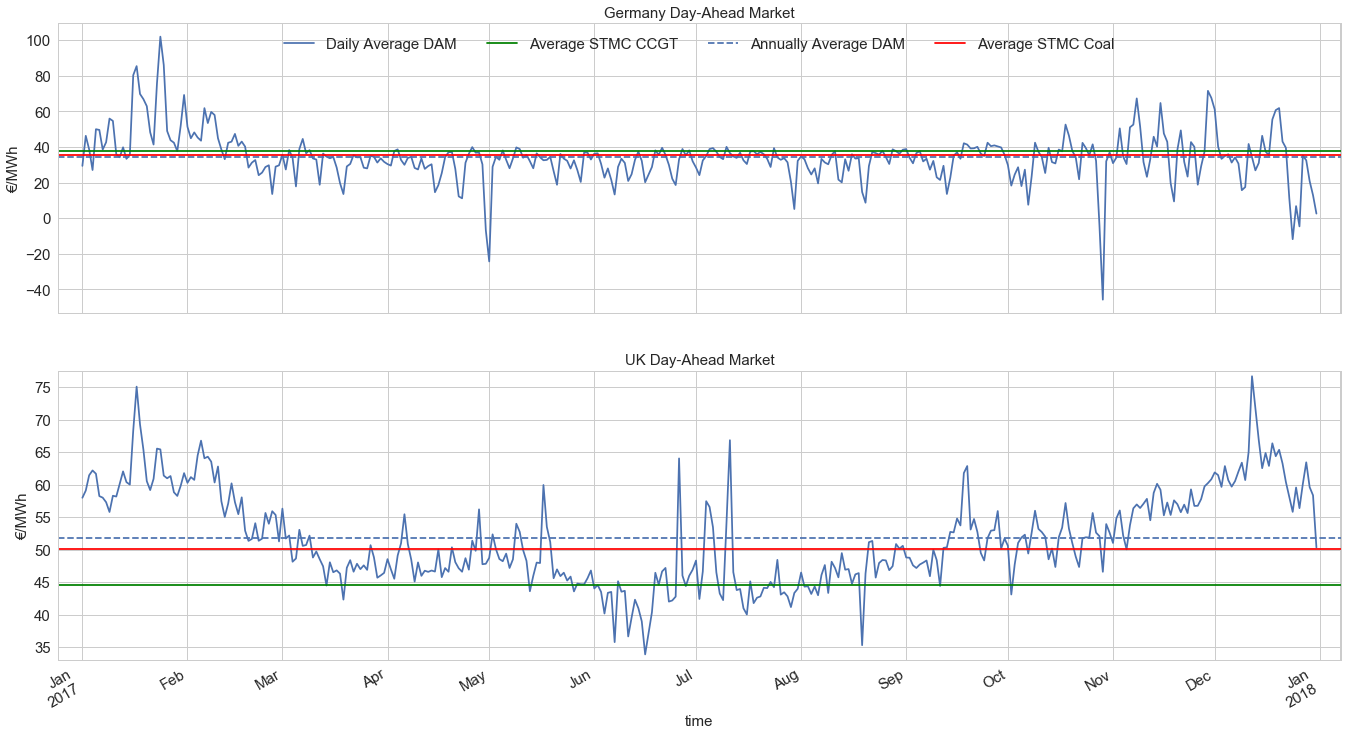

In [25]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ccgt_ge.electricity.resample('D').mean().plot(ax=ax[0], label='Daily Average DAM')
ax[0].axhline(y= CCGT_GE.Finance_Metrics['Average STMC'], color='green', label='Average STMC CCGT')
ax[0].axhline(y= ccgt_ge.electricity.mean(), linestyle = '--', label='Annually Average DAM')
ax[0].axhline(y= Coal_GE.Finance_Metrics['Average STMC'], color='red', label='Average STMC Coal')
ax[0].legend(shadow='False', loc='upper center', ncol=4)
ax[0].set_ylabel('€/MWh')
ax[0].set_title('Germany Day-Ahead Market')

gas_uk.electricity.resample('D').mean().plot(ax=ax[1], label='Daily Average DAM')
ax[1].axhline(y= CCGT_UK.Finance_Metrics['Average STMC'], color='green', label='Annually Average STMC CCGT')
ax[1].axhline(y= gas_uk.electricity.mean(), linestyle = '--', label='Annually Average DAM')
ax[1].axhline(y= Coal_UK.Finance_Metrics['Average STMC'], color='red', label='Annually Average STMC Coal')
ax[1].set_ylabel('€/MWh')
ax[1].set_title('UK Day-Ahead Market')

fig.autofmt_xdate()
plt.margins(0.02)

The situation is quite different in the UK, however. Coal is virtually phased out due to the Carbon Price Floor Mechanism established in the UK which set the floor price for carbon at £ 18/ ton $CO_{2}$ (20.5 €), while the carbon price in Germany is determined through the European Trading Scheme and fluctuates between 4.5 and 5.5 € / ton $CO_{2}$. Nevertheless, gas is still the biggest source for electricity generation in the UK in 2017. This is , in fact, owing to relatively high electricity price of the UK, which, in turns, is due to the lack of grid interconnection in the UK (only one high voltage DC line connecting to France).  

![Mix](pic/UK_Mix_2017.png)

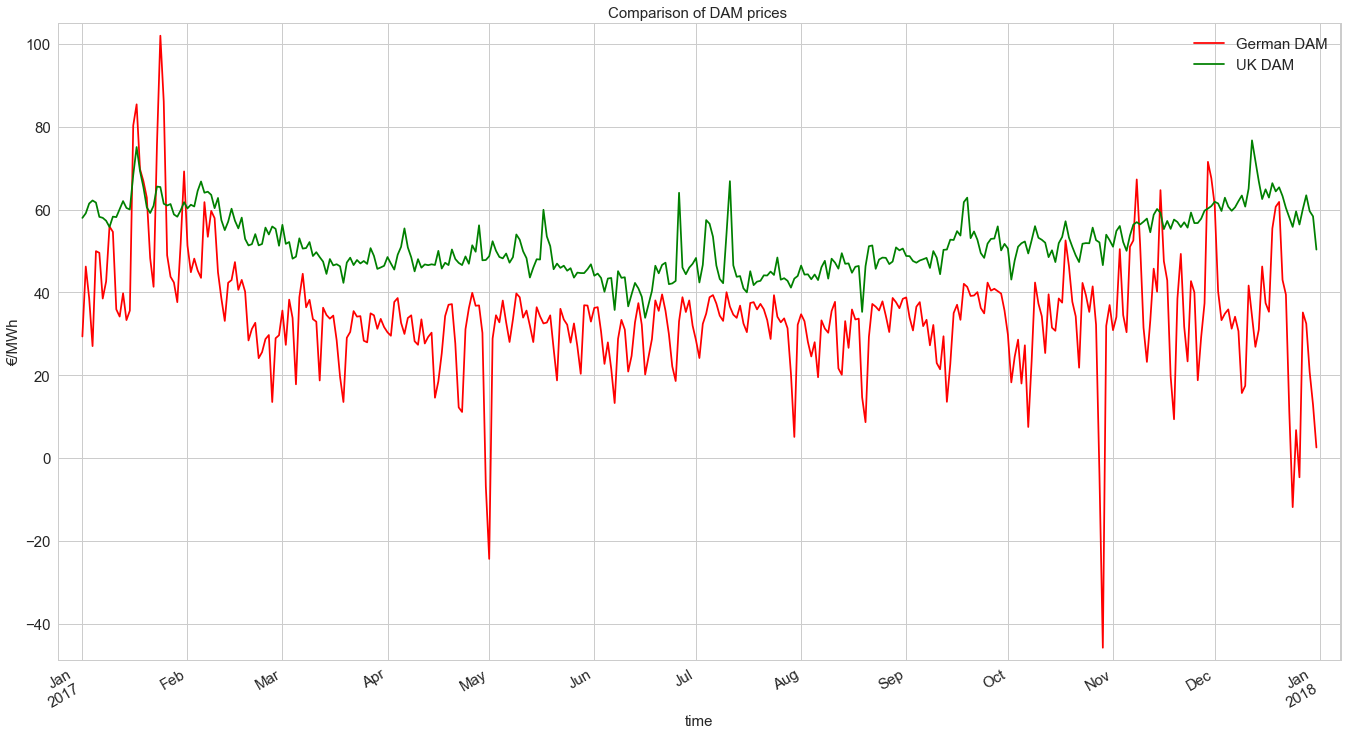

In [26]:
fig, ax = plt.subplots()
ccgt_ge.electricity.resample('D').mean().plot(color='red', label='German DAM')
gas_uk.electricity.resample('D').mean().plot(color='green', label='UK DAM')
fig.autofmt_xdate()
ax.legend(shadow='False', loc='best')
ax.set_ylabel('€/MWh')
ax.set_title('Comparison of DAM prices ')
plt.margins(0.02)

We can clearly see that there is a correlation between gas price and the electricity in the UK. 

In [27]:
# Daily Average price 
commodity_uk_daily = gas_uk.drop('carbon', axis=1)
commodity_uk_daily = commodity_uk_daily.resample('D').mean()

# Weekly Average price 
commodity_uk_weekly = gas_uk.drop('carbon', axis=1)
commodity_uk_weekly = commodity_uk_weekly.resample('W').mean()

# Calculate the variation in prices  
relative_uk_daily = commodity_uk_daily.pct_change()
relative_uk_weekly = commodity_uk_weekly.pct_change()

A simple correlation test can be conducted to show that there is a sort of correlation between the weekly gas and electricity prices. Of course, more advanced correlation tests for time series have to be conducted to thoroughly investigate the correlation between these prices (rolling correlation, cointegration)   

In [28]:
print('Daily Price Variation Correlation', relative_uk_daily['fossil'].corr(relative_uk_daily['electricity']))
print('Weakly Price Variation Correlation', relative_uk_weekly['fossil'].corr(relative_uk_weekly['electricity']))

Daily Price Variation Correlation 0.092954945021867
Weakly Price Variation Correlation 0.5077982254528295


Text(0,0.5,'€/MWh')

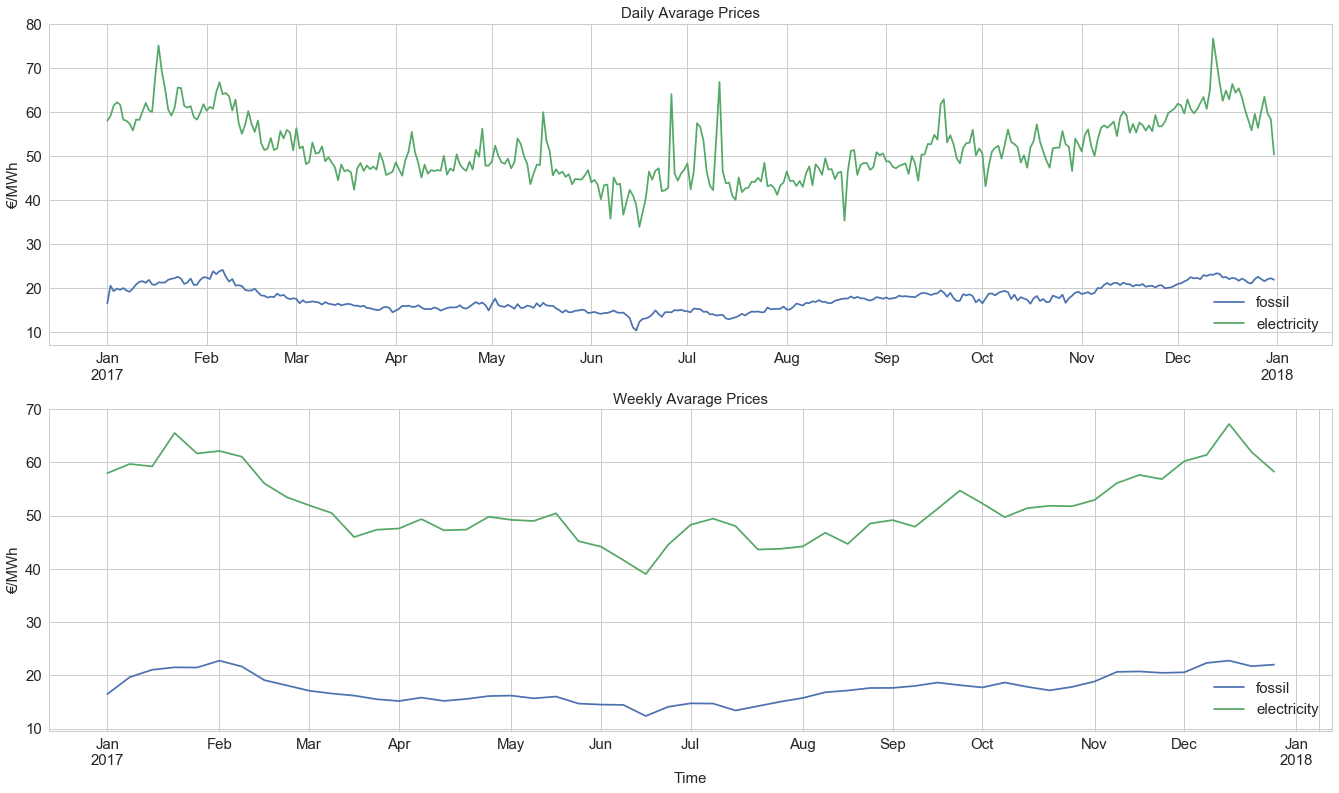

In [29]:
fig, ax = plt.subplots(2)

commodity_uk_daily.plot(title='Daily Avarage Prices', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('€/MWh')

commodity_uk_weekly.plot(title='Weekly Avarage Prices', ax=ax[1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('€/MWh')

As opposed to the case in the UK, there is no clear visual correlation between gas and electricity price in Germany.

In [30]:
# Daily Average price 
commodity_ge_daily = ccgt_ge.drop('carbon', axis=1)
commodity_ge_daily = commodity_ge_daily.resample('D').mean()

# Weekly Average price 
commodity_ge_weekly = ccgt_ge.drop('carbon', axis=1)
commodity_ge_weekly = commodity_ge_weekly.resample('W').mean()

# Calculate the variation in prices  
relative_ge_daily = commodity_ge_daily.pct_change()
relative_ge_weekly = commodity_ge_weekly.pct_change()

In [31]:
print('Daily Price Variation Correlation', relative_ge_daily['fossil'].corr(relative_ge_daily['electricity']))
print('Weakly Price Variation Correlation', relative_ge_weekly['fossil'].corr(relative_ge_weekly['electricity']))

Daily Price Variation Correlation 0.018857425084416544
Weakly Price Variation Correlation -0.05310854874786422


Text(0,0.5,'€/MWh')

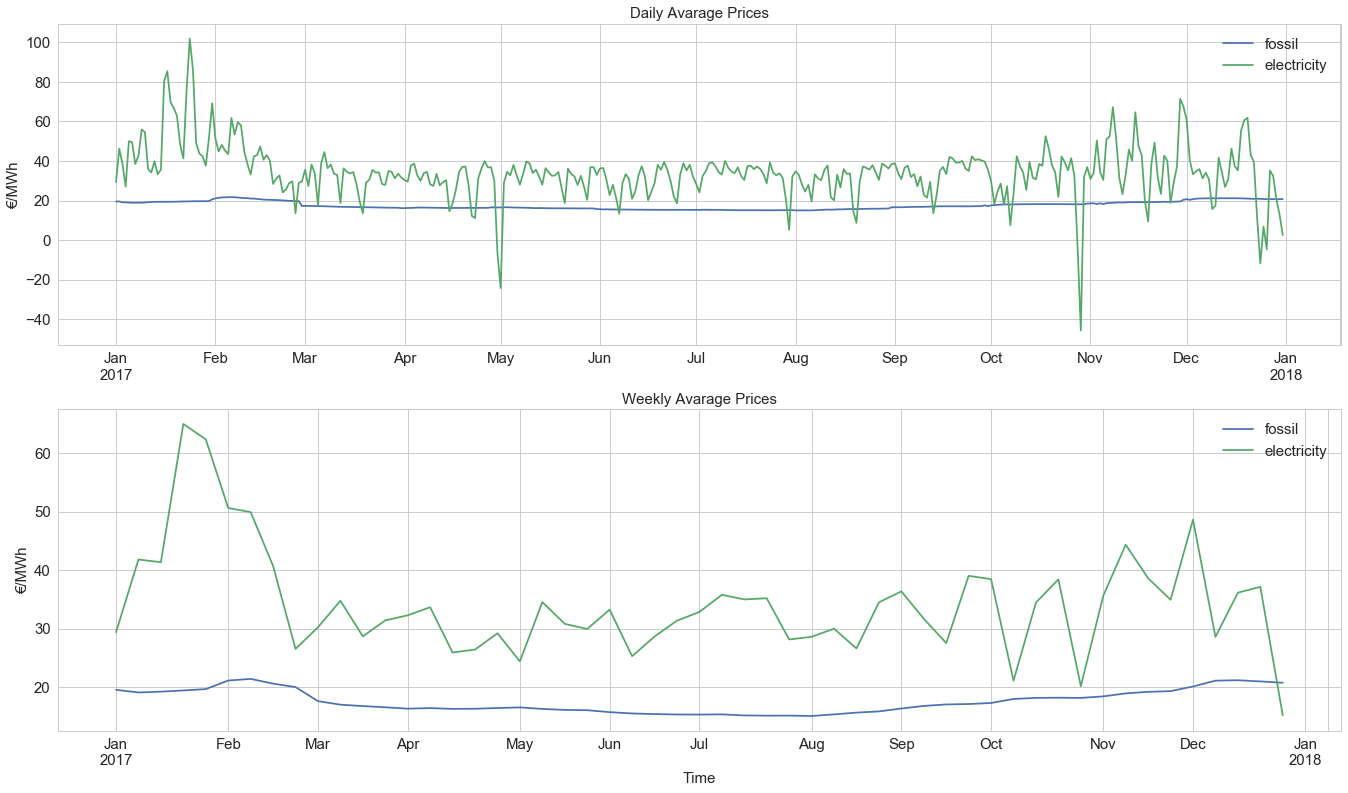

In [32]:
fig, ax = plt.subplots(2)

commodity_ge_daily.plot(title='Daily Avarage Prices', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('€/MWh')

commodity_ge_weekly.plot(title='Weekly Avarage Prices', ax=ax[1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('€/MWh')